In [2]:
# -----------------------------
# 0) Import Libraries
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, roc_curve,
                             precision_recall_curve)
import shap
import joblib

In [3]:
# ================================
# 1) Load dataset & models
# ================================
master = pd.read_csv("data/master_dataset.csv")
X_test = master.drop(columns=["Provider","Fraud"])
y_test = master["Fraud"]

rf = joblib.load("models/rf.pkl")
smote_pipeline = joblib.load("models/xgb_smote.pkl")
logreg = joblib.load("models/logreg.pkl")
gb = joblib.load("models/gb.pkl")


In [5]:
# ================================
# 2) Evaluation Functions
# ================================
def evaluate(model, X_test, y_test, name):
    probs = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.predict(X_test)
    preds = (probs > 0.5).astype(int)
    print(f"===== {name} =====")
    print("Precision:", precision_score(y_test, preds))
    print("Recall:", recall_score(y_test, preds))
    print("F1:", f1_score(y_test, preds))
    print("ROC-AUC:", roc_auc_score(y_test, probs))
    print("PR-AUC:", average_precision_score(y_test, probs))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    return probs, preds

def plot_curves(y_test, probs, title):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(recall, precision); plt.title("PR Curve - " + title); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.subplot(1,2,2); plt.plot(fpr, tpr); plt.title("ROC Curve - " + title); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.show()

===== Random Forest =====
Precision: 0.9600840336134454
Recall: 0.9031620553359684
F1: 0.9307535641547862
ROC-AUC: 0.9944153034709103
PR-AUC: 0.9638607210863517
Confusion Matrix:
 [[4885   19]
 [  49  457]]
===== XGBoost + SMOTE =====
Precision: 0.6317241379310344
Recall: 0.9051383399209486
F1: 0.7441104792851341
ROC-AUC: 0.9794895995202755
PR-AUC: 0.8817536693470732
Confusion Matrix:
 [[4637  267]
 [  48  458]]
===== Logistic Regression =====
Precision: 0.2607184241019699
Recall: 0.8893280632411067
F1: 0.4032258064516129
ROC-AUC: 0.8847061203566985
PR-AUC: 0.6706486023742417
Confusion Matrix:
 [[3628 1276]
 [  56  450]]
===== Gradient Boosting =====
Precision: 0.9494505494505494
Recall: 0.8537549407114624
F1: 0.899063475546306
ROC-AUC: 0.9907140013153737
PR-AUC: 0.9408854985921621
Confusion Matrix:
 [[4881   23]
 [  74  432]]


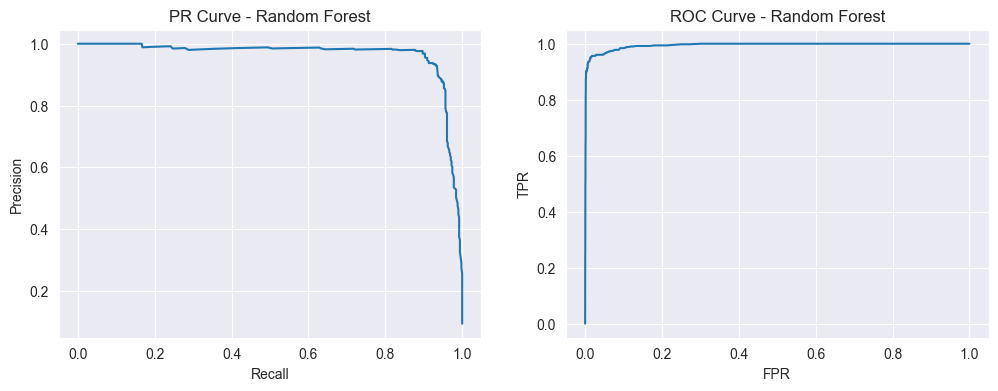

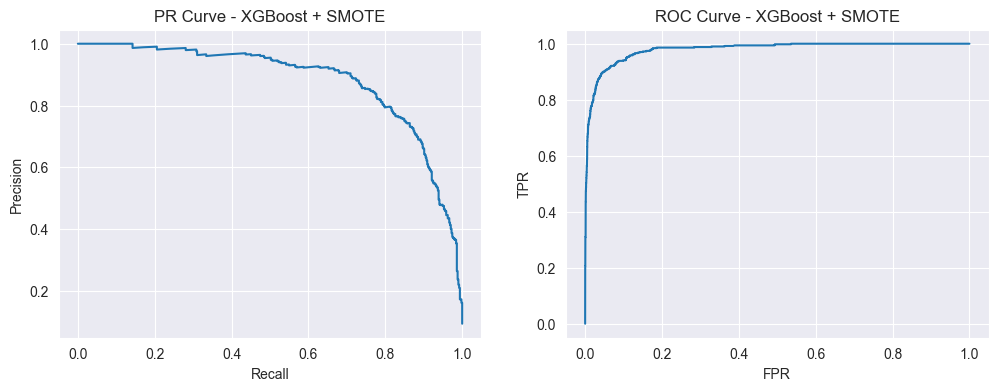

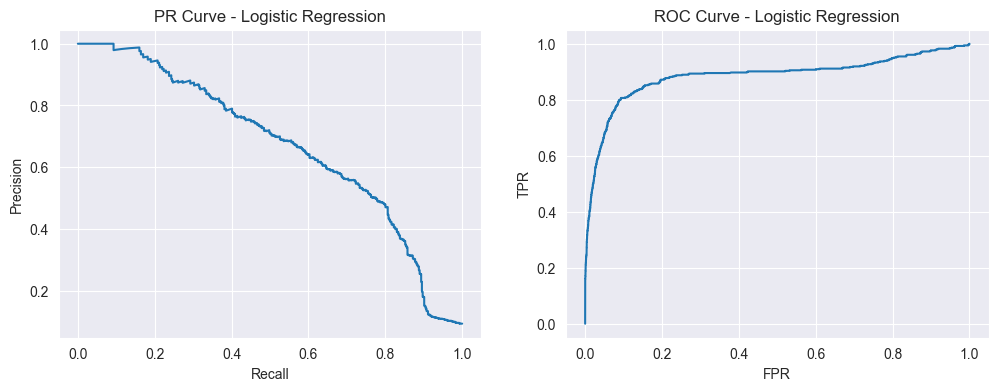

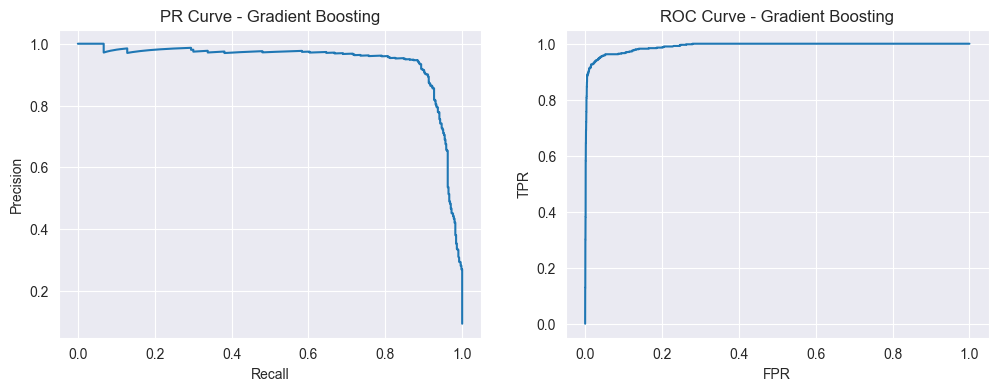

In [6]:
# ================================
# 3) Evaluate all models
# ================================
rf_probs, rf_preds = evaluate(rf, X_test, y_test, "Random Forest")
xgb_probs, xgb_preds = evaluate(smote_pipeline, X_test, y_test, "XGBoost + SMOTE")
log_probs, log_preds = evaluate(logreg, X_test, y_test, "Logistic Regression")
gb_probs, gb_preds = evaluate(gb, X_test, y_test, "Gradient Boosting")

plot_curves(y_test, rf_probs, "Random Forest")
plot_curves(y_test, xgb_probs, "XGBoost + SMOTE")
plot_curves(y_test, log_probs, "Logistic Regression")
plot_curves(y_test, gb_probs, "Gradient Boosting")

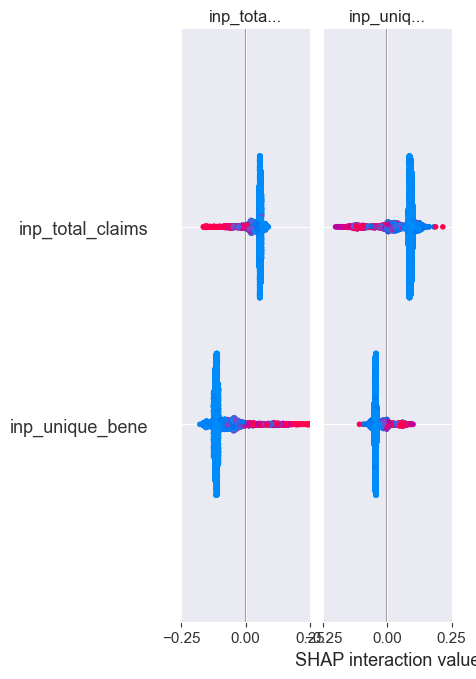

In [7]:
# ================================
# 4) SHAP Analysis (Random Forest)
# ================================
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values
shap.summary_plot(shap_class1, X_test)

In [8]:
# ================================
# 5) Error Analysis
# ================================
test_df = master.copy()
test_df["RF_pred"] = rf_preds
test_df["y_true"] = y_test.values

FP_rf = test_df[(test_df.y_true==0) & (test_df.RF_pred==1)].head(3)
FN_rf = test_df[(test_df.y_true==1) & (test_df.RF_pred==0)].head(3)

display(FP_rf)
display(FN_rf)

,Provider,Fraud,inp_total_claims,inp_unique_bene,inp_sum_InscClaimAmtReimbursed,inp_mean_InscClaimAmtReimbursed,inp_sum_DeductibleAmtPaid,inp_mean_DeductibleAmtPaid,out_total_claims,out_unique_bene,out_sum_InscClaimAmtReimbursed,out_mean_InscClaimAmtReimbursed,out_sum_DeductibleAmtPaid,out_mean_DeductibleAmtPaid,RF_pred,y_true
269,PRV51342,0,28.0,28.0,319000.0,11392.857143,28836.0,1068.0,179.0,154.0,37780.0,211.061453,530.0,2.960894,1,0
361,PRV51456,0,112.0,103.0,1036690.0,9256.160714,117480.0,1068.0,23.0,21.0,2300.0,100.000000,0.0,0.000000,1,0
852,PRV52063,0,88.0,73.0,919000.0,10443.181818,91848.0,1068.0,704.0,655.0,197210.0,280.127841,1640.0,2.329545,1,0


,Provider,Fraud,inp_total_claims,inp_unique_bene,inp_sum_InscClaimAmtReimbursed,inp_mean_InscClaimAmtReimbursed,inp_sum_DeductibleAmtPaid,inp_mean_DeductibleAmtPaid,out_total_claims,out_unique_bene,out_sum_InscClaimAmtReimbursed,out_mean_InscClaimAmtReimbursed,out_sum_DeductibleAmtPaid,out_mean_DeductibleAmtPaid,RF_pred,y_true
3,PRV51005,1,0.0,0.0,0.0,0.0,0.0,0.0,1165.0,495.0,280910.0,241.124464,3700.0,3.175966,0,1
44,PRV51059,1,25.0,23.0,401000.0,16040.0,26700.0,1068.0,71.0,60.0,20060.0,282.535211,240.0,3.380282,0,1
96,PRV51126,1,20.0,14.0,177000.0,8850.0,21360.0,1068.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0,1
